In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, losses
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

import numpy as np
from numpy.linalg import pinv

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

In [ ]:
#Importação dos features/labels de treino e features/labels de teste do MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar os dados
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Adicionar uma dimensão de canal
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

11490434/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [ ]:
x_train_shape = (28, 28, 1)

# Encoder
hidden_size = 100
latent_size = 20

input_layer = layers.Input(shape=x_train_shape)
flattened = layers.Flatten()(input_layer)
hidden = layers.Dense(hidden_size, activation='relu')(flattened)
latent = layers.Dense(latent_size, activation='relu')(hidden)
encoder = Model(inputs=input_layer, outputs=latent, name='encoder')
encoder.summary()

# Decoder
input_layer_decoder = layers.Input(shape=(latent_size,))
upsampled = layers.Dense(hidden_size, activation='relu')(input_layer_decoder)
upsampled = layers.Dense(encoder.layers[1].output_shape[-1], activation='relu')(upsampled)
constructed = layers.Reshape(x_train_shape)(upsampled)
decoder = Model(inputs=input_layer_decoder, outputs=constructed, name='decoder')
decoder.summary()

# Autoencoder (combinação do encoder e decoder)
autoencoder_input = layers.Input(shape=x_train_shape)
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(inputs=autoencoder_input, outputs=decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
Total params: 80520 (314.53 KB)
Trainable params: 80520 (314.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp

Epoch 1/10
235/235 [==============================] - 7s 21ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 2/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 3/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 4/10
235/235 [==============================] - 5s 21ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 5/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 6/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 7/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 8/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 9/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 10/10
313/313 [==============================] - 1s 3ms/step


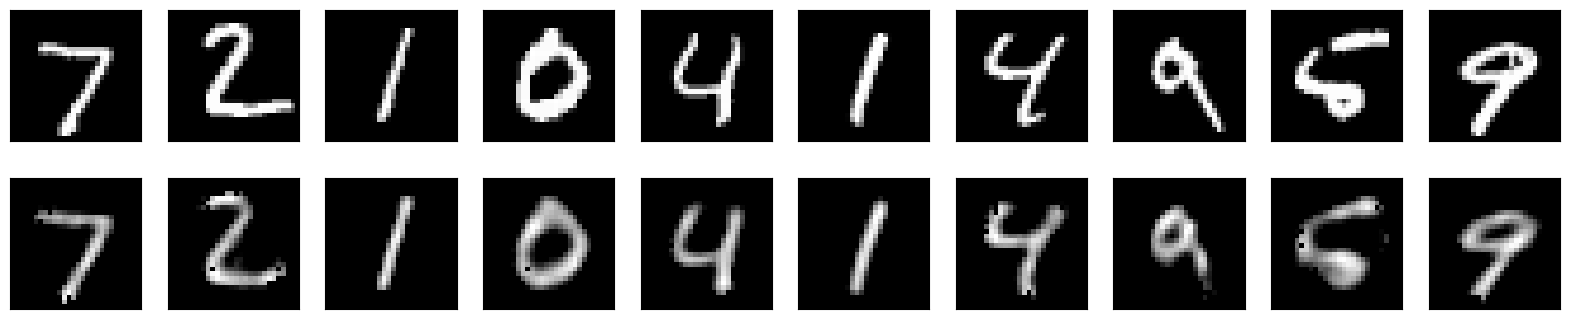

In [ ]:
# Compilar o autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o autoencoder
autoencoder.fit(x_train, x_train, epochs = 10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Fazer previsões (reconstruções) no conjunto de teste
decoded_imgs = autoencoder.predict(x_test)

# Visualizar as imagens originais e reconstruídas
n = 10  # número de dígitos para visualizar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagens originais
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagens reconstruídas
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

  # ELM classifyng Autoended Images:

In [ ]:
np.random.seed(1349)

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

# Achatar as imagens reconstruídas para o ELM
decoded_imgs_flat = decoded_imgs.reshape(decoded_imgs.shape[0], -1)

# One-hot encoding das labels
encoder_onehot = OneHotEncoder(sparse=False)
y_train_onehot = encoder_onehot.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder_onehot.transform(y_test.reshape(-1, 1))

# Parâmetros do modelo ELM
input_size = decoded_imgs_flat.shape[1]
hidden_size = 1000  # número de neurônios na camada oculta
output_size = y_train_onehot.shape[1]

# Inicializar pesos da camada oculta aleatoriamente
W = np.random.randn(input_size, hidden_size)
b = np.random.randn(hidden_size)

# Função de ativação da camada oculta (ReLU)
def relu(x):
    return np.maximum(0, x)

# Calcular a saída da camada oculta para os dados de treino reconstruídos
H_train = relu(np.dot(decoded_imgs_flat, W) + b)

# Calcular os pesos da camada de saída usando pseudoinversa
H_pinv = pinv(H_train)
beta = np.dot(H_pinv, y_test_onehot)

# Fazer previsões no conjunto de teste usando as imagens reconstruídas
H_test = relu(np.dot(decoded_imgs_flat, W) + b)
y_pred = np.dot(H_test, beta)

# Converter as previsões para labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Avaliar a acurácia
accuracy = np.mean(y_pred_labels == y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

313/313 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test accuracy: 97.65%


Confusion Matrix:
[[ 970    0    1    2    0    2    3    1    1    0]
 [   0 1124    4    3    0    1    2    1    0    0]
 [   3    1 1010    1    3    1    3    5    5    0]
 [   0    0    5  980    0   10    0    7    4    4]
 [   1    2    3    0  954    0    3    1    1   17]
 [   3    0    0   10    1  865    7    0    3    3]
 [   4    3    0    0    2    2  946    0    1    0]
 [   0    5    6    0    5    0    0 1003    1    8]
 [   4    0    1    4    3    6    2    2  951    1]
 [   5    6    2    7   18    1    0    8    0  962]]


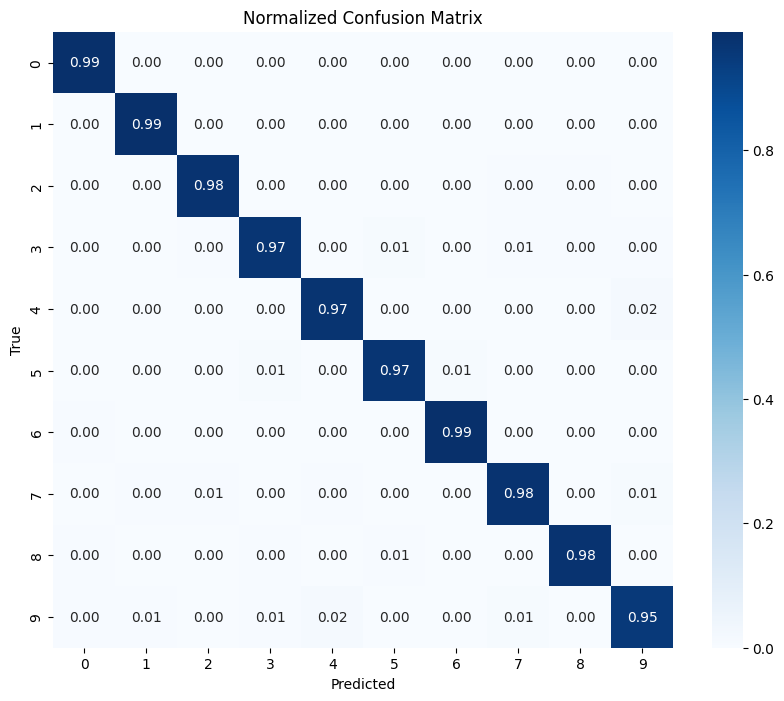

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Normalizar a matriz de confusão por linha (por classe verdadeira)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão normalizada de forma visual
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Relatório de classificação
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

In [ ]:
import tensorflow as tf
import visualkeras
'''
# Defina seu modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])
'''
# Gere a imagem da arquitetura
visualkeras.layered_view(decoder, to_file='model.png').show()

# Arquitetura do Modelo:

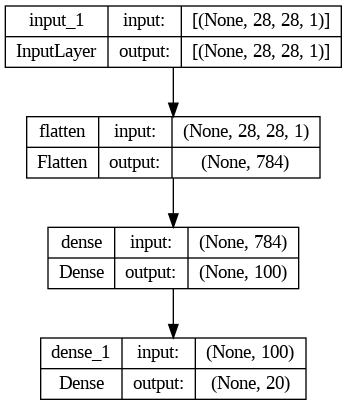

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(encoder, to_file='model.png', show_shapes=True, show_layer_names=True)

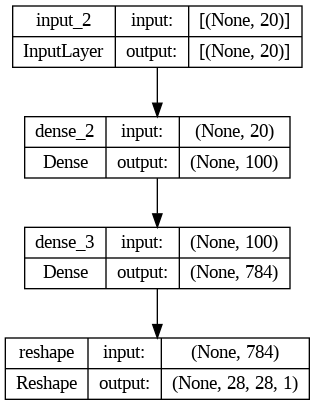

In [ ]:
plot_model(decoder, to_file='model.png', show_shapes=True, show_layer_names=True)

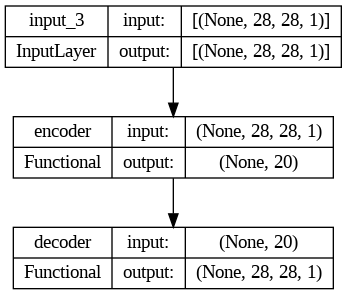

In [ ]:
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)